# Bayesian Deep Learning in Push

## Introduction

In this notebook, we will demonstrate various features of Push by using it to train a **deep ensemble** on a sine wave:

$$
\begin{align}
    y & = sin(x) + \epsilon \\
    \epsilon & \sim \mathcal{N}(0, 0.05) \,.
\end{align}
$$

A deep ensemble is one of many methods for performing **Bayesian deep learning** (BDL). BDL applies **Bayesian inference** to neural networks (NNs) in the hopes of enabling additional capabilities such as **uncertainty quantification**. For more background on BDL, we recommend Kevin Murphy's excellent book "Probabilistic Machine Learning: Advanced Topics, Kevin Murphy, Chapter 17" on BDL.

### Dataset

We set up the sine wave dataset now with $D = 1$ dimensions defined on the interval $(-2\pi, 2\pi)$ with $N = 2048$ data points.

In [1]:
import math
from bdl import SineWithNoiseDataset

D = 1                                  # dimensions
N = 2048                               # number of points
train_begin_radians = -2 * math.pi     # left interval
train_end_radians = 2 * math.pi        # right interval

# Define the dataset as a PyTorch dataset
dataset = SineWithNoiseDataset(N, D, train_begin_radians, train_end_radians)

### Plotting the Dataset 

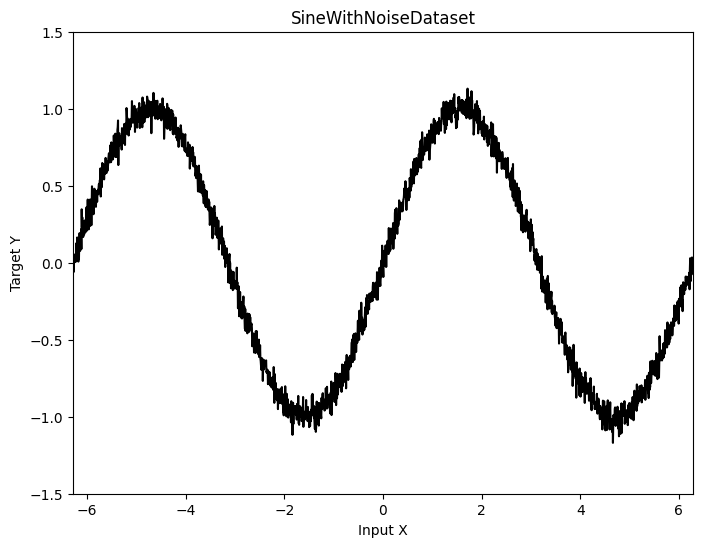

In [2]:
import matplotlib.pyplot as plt

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.plot(dataset.xs, dataset.ys, c ='black')
plt.title('SineWithNoiseDataset')
plt.xlabel('Input X')
plt.ylabel('Target Y')
plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.show()

## Defining Models in Push with Particles

Users can represent a Bayesian neural network (BNN) in Push as a concurrently-executing and communicating ensemble of **particles**. This consists of two components.

1. Push provides functionality to wrap an arbitrary PyTorch module as a **particle**. This enables Push users to use a wide range of predefined models.
2. Push enables orchestrating ensembles of particles, concurrent execution of particles, and communications between particles using the `PusH` construct.

### Model Part 1: Neural Network Architecture Template

For the purposes of this tutorial, we introduce a simple neural network (NN) model now. This NN architecture will be used as a template to create instances of particles.

In [3]:
# Import the neural network
from bdl import MiniNN, BiggerNN

Each `MiniNN` contains two fully-connected layers of dimension $D$ and uses a ReLU activation function. The code is contained in the module `bdl`.
```py
class MiniNN(nn.Module):
    def __init__(self, D):
        super(MiniNN, self).__init__()
        self.fc1 = nn.Linear(D, D)
        self.fc2 = nn.Linear(D, D)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x 
```

A `BiggerNN` is built out of $n$ `MiniNN` NN blocks so we can vary the size of the network to explore how the number of layers affects our results. 
```py
class BiggerNN(nn.Module):
    def __init__(self, n, input_dim, output_dim, hidden_dim):
        super(BiggerNN, self).__init__()
        self.minis = []
        self.n = n
       
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        for i in range(0, n):
            self.minis += [MiniNN(hidden_dim)]
            self.add_module("mini_layer"+str(i), self.minis[-1])
        self.fc = nn.Linear(hidden_dim, output_dim)
            
    def forward(self, x):
        x = self.input_layer(x)
        for i in range(0, self.n):
            x = self.minis[i](x)
        return self.fc(x)
```

### Model Part 2: Ensemble of Particles

The construct `PusH` enables Push users to orchestrate a communicating ensemble of particles. The `PusH` object runs on a separate process from the calling process so that it can execute the semantics of particles separately from the calling process. We give an example of calling `PusH` with the arguments below now.

1. `mk_nn`: the NN architecture used as a template to create particles.
2. `*args`: the hyperparameters for the NN architecture. For a `BiggerNN`, this includes the number of `MiniNN` layers, the size of the input dimension, the size of the output dimension, and the size of the hidden dimension.

```py
import push.push

# Create a communicating ensemble of particles using mk_nn(*args) as a template.
with push.push.PusH(mk_nn, *args) as push_dist:
    pids = []
    for i in range(num_ensembles):
        # 1. Each particle has a unique `pid`.
        # 2. `mk_optim` is a particle specific optimization method as in standard PyTorch.
        # 3. Create a particle on device 0.
        # 4. `receive` determines how each particle .
        # 5. `state` is the state associated with each particle.
        pids += [push_dist.p_create(mk_optim, device=0, receive={}, state={})]
```

## Training Models in Push

After we have defined a `PusH` object, we can use the orchestration capabilities of Push to train each particle, possibly with interaction between different particles during training. In this tutorial, we choose one of the simplest methods--deep ensembles--where there is no communication between different particles.

### Training Deep Ensembles in Push

A deep ensemble with $k$ ensembles trains $k$ instances of a NN architecture to obtains $k$ independently-trained models. Each trained model can be interpreted as the parameter setting corresponding to a sample from a suitably defined posterior distribution on NN parameters. In this way, a deep ensemble can be seen as a BDL method. To run a deep ensemble we will be using the `bayes.ensemble.train_deep_ensemble` function. This function requires the following to run.

1. A **dataloader** (`torch.utils.data`)
2. A **loss** function i.e. (`torch.nn.MSELoss`)
3. The number of **epochs** (`int`)
4. A **model** class (`torch.nn.Module`)
5. The model class's initialization parameters (`*args`)
6. The number of **devices** (GPUs) to use (`int`)
7. The number of **models** to be ensembles (`int`)

and returns the Ensemble object. The Ensemble object can perform inference with its member function `posterior_pred`

```python
def train_deep_ensemble(dataloader: Callable, loss_fn: Callable, epochs: int,
                        nn: Callable, *args, num_devices: int = 1, cache_size: int = 4, view_size: int = 4,
                        num_ensembles: int = 2, mk_optim = mk_optim,
                        ensemble_entry = _deep_ensemble_main, ensemble_state={}) -> List[torch.Tensor]:
    ensemble = Ensemble(nn, *args, num_devices=num_devices, cache_size=cache_size, view_size=view_size)
    ensemble.bayes_infer(dataloader, epochs, loss_fn=loss_fn, num_ensembles=num_ensembles, mk_optim=mk_optim,
                         ensemble_entry=ensemble_entry, ensemble_state=ensemble_state)
    return ensemble
```

In [14]:
import torch
from torch.utils.data import DataLoader

import push.bayes.ensemble

# 1. Create dataloader
batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 2. Model hyperparameters
n = 4
input_dim = 1
output_dim = 1
hidden_dim = 64
epochs = 1000
num_devices = 2

# 3. Train two particles
print('Training two particles ...')
two_particle_ensemble = push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        BiggerNN, n, input_dim, output_dim, hidden_dim,
        num_devices=num_devices,
        num_ensembles=2,
    )

Training two particles ...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:04<00:00, 15.50it/s]


#### Training more ensembles

In [15]:
# Four particles
print('Training four particles ...')
four_particle_ensemble = push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        BiggerNN, n, input_dim, output_dim, hidden_dim,
        num_devices=num_devices,
        num_ensembles=4
    )

# Eight particles
print('Training eight particles ...')
eight_particle_ensemble = push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        BiggerNN, n, input_dim, output_dim, hidden_dim,
        num_devices=num_devices,
        num_ensembles=8
    )

Training four particles ...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:42<00:00,  9.75it/s]


Training eight particles ...


100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]


### Test Data
We set up the test dataset now with the sine wave of $D = 1$ dimensions defined on the interval $(-8\pi, 8\pi)$ with $N = 2048$ data points.

In [16]:
import numpy as np
test_begin_radians = -8 * math.pi
test_end_radians = 8 * math.pi
oos_dataset = SineWithNoiseDataset(N, D, test_begin_radians, test_end_radians)
test_dataloader = DataLoader(oos_dataset, batch_size=64, shuffle=False)
oos_xs = oos_dataset.xs
oos_ys = oos_dataset.ys

# Extract the data
xs = dataset.xs
ys = dataset.ys

# Flatten our x values for out of sample
x_flat = xs.view(-1).numpy()
oos_x_flat = oos_xs.view(-1).numpy()

### Performing Inference
The `Ensemble` class implements the `posterior_pred` function which can compute the mean, median, min, and max predictions over our `PusH` distribution's particles. Inference is handled on the particle level, with each particle performing inference concurrently. With our `Ensemble` objects obtained from training we will pass in our test dataloader to the `posterior_pred` and specify the `mode`(s) of prediction we would like (mean, median, min, and/or max).

`posterior_pred` returns a `dict` containing prediction results, with the selected `mode` values as keys.

In [17]:
two_particle_outputs = two_particle_ensemble.posterior_pred(test_dataloader, mode=["mean","median","min","max", "std"])
four_particle_outputs = four_particle_ensemble.posterior_pred(test_dataloader, mode=["mean","median","min","max", "std"])
eight_particle_outputs = eight_particle_ensemble.posterior_pred(test_dataloader, mode=["mean","median","min","max", "std"])

## Uncertainty

### Aleotoric vs Epistemic
Uncertainty in the context of machine learning can be classified as either aleotoric or epistemic.

#### Aleotoric Uncertainty
Aleoric uncertainty is inherent in the data itself, and arises from the stochastic nature of the underlying processs for how the data was generated. In this example's dataset, the added noise term $\epsilon$ is the source of aleotoric uncertainty. 

#### Epistemic Uncertainty
Epistemic uncertainty is the uncertainty present in the model itself. Epistemic uncertainty can often stem from limited data or model complexity, and this example we demonstrate how a lack of data effects epistemic uncertainty by training our ensemble on the interval $(-2\pi, 2\pi)$, and testing on the interval $(-8\pi, 8\pi)$. We visualize epistemic uncertainty by plotting the confidence interval of predictions over our ensemble.

### Plotting our Results

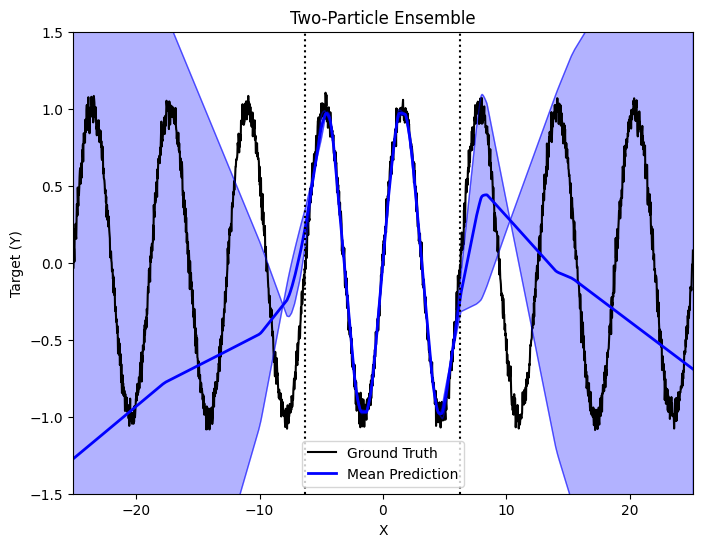

In [25]:
plt.figure(figsize=(8, 6))
pred_upper = two_particle_outputs["mean"] + two_particle_outputs["std"]
pred_lower = two_particle_outputs["mean"] - two_particle_outputs["std"]
plt.plot(oos_xs, oos_ys, c="black", label="Ground Truth")
plt.plot(oos_xs, two_particle_outputs["mean"], color="blue", lw=2, label="Mean Prediction")
plt.plot(oos_xs, pred_upper, "-b", alpha=0.5, lw=1)
plt.plot(oos_xs, pred_lower, "-b", alpha=0.5, lw=1)
plt.fill_between(oos_x_flat, pred_lower.flatten(), pred_upper.flatten(), color='blue', alpha=0.3)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)

plt.ylim(-1.5, 1.5)
plt.title('Two-Particle Ensemble')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


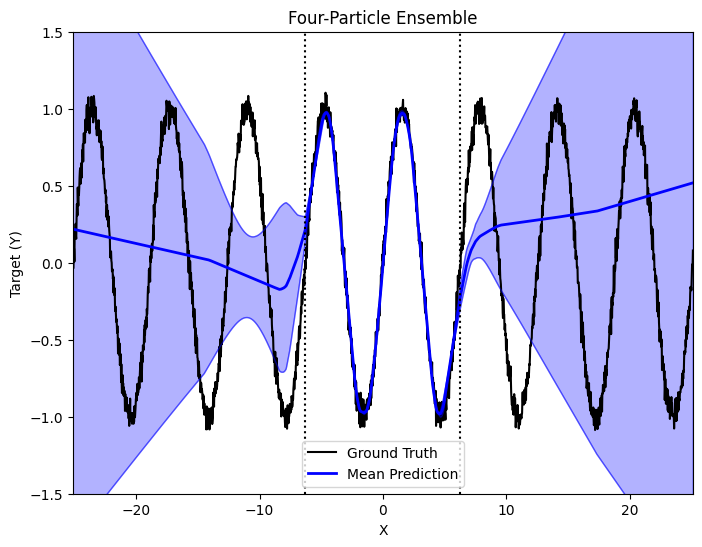

In [26]:
plt.figure(figsize=(8, 6))
pred_upper = four_particle_outputs["mean"] + four_particle_outputs["std"]
pred_lower = four_particle_outputs["mean"] - four_particle_outputs["std"]
plt.plot(oos_xs, oos_ys, c="black", label="Ground Truth")
plt.plot(oos_xs, four_particle_outputs["mean"], color="blue", lw=2, label="Mean Prediction")
plt.plot(oos_xs, pred_upper, "-b", alpha=0.5, lw=1)
plt.plot(oos_xs, pred_lower, "-b", alpha=0.5, lw=1)
plt.fill_between(oos_x_flat, pred_lower.flatten(), pred_upper.flatten(), color='blue', alpha=0.3)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.title('Four-Particle Ensemble')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


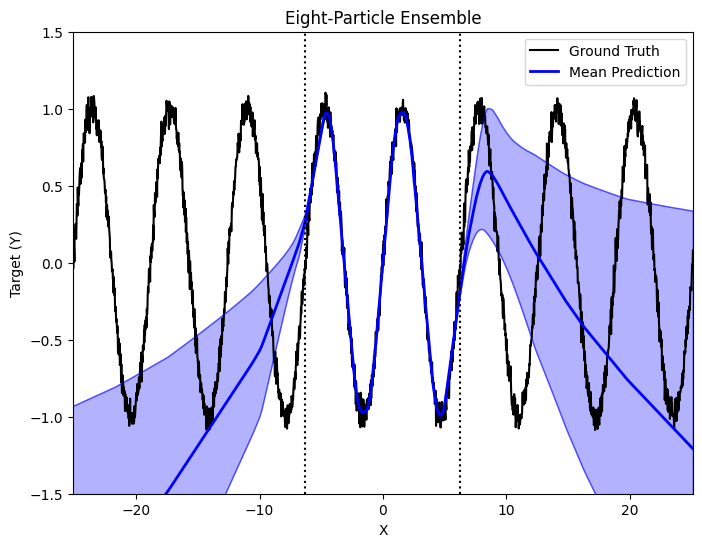

In [27]:
plt.figure(figsize=(8, 6))
pred_upper = eight_particle_outputs["mean"] + eight_particle_outputs["std"]
pred_lower = eight_particle_outputs["mean"] - eight_particle_outputs["std"]
plt.plot(oos_xs, oos_ys, c="black", label="Ground Truth")
plt.plot(oos_xs, eight_particle_outputs["mean"], color="blue", lw=2, label="Mean Prediction")
plt.plot(oos_xs, pred_upper, "-b", alpha=0.5, lw=1)
plt.plot(oos_xs, pred_lower, "-b", alpha=0.5, lw=1)
plt.fill_between(oos_x_flat, pred_lower.flatten(), pred_upper.flatten(), color='blue', alpha=0.3)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.title('Eight-Particle Ensemble')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


References:

[1] A.G. Wilson, P. Izmailov. Bayesian Deep Learning and a Probabilistic Perspective of Generalization. Advances in Neural Information Processing Systems, 2020.